In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def get_stats(df, lang, model_name):
    # Initialize prior success count
    prior_func_sec = 0

    unique_attempts = df['attempt'].unique()

    stats_df = pd.DataFrame(columns=['lang', 'model_name', 'attempt', 'compiles', 'functional', 'secure', 'func_secure'])

    # Iterate through attempts and calculate success rates
    for attempt in sorted(unique_attempts):
        attempt_df = df[df['attempt'] == attempt]

        # If the model was able to succeed (generate functional+secure code) in a prior attempt, we should count this as a success by this attempt
        tot = len(attempt_df) + prior_func_sec
        compiled = attempt_df['compiles'].sum() + prior_func_sec
        functional = attempt_df['functional'].sum() + prior_func_sec
        secure = attempt_df['secure'].sum() + prior_func_sec
        func_secure = attempt_df['func_secure'].sum() + prior_func_sec

        prior_func_sec = func_secure

        stats_df = pd.concat([stats_df, pd.DataFrame({
            'lang': lang,
            'model_name': model_name,
            'attempt': attempt,
            'compiles': compiled,
            'functional': functional,
            'secure': secure,
            'func_secure': func_secure,
            'total': tot
        }, index=[0])], ignore_index=True)

    return stats_df

In [3]:
all_lang_stats = []
lang_to_stats = {}

for filename in os.listdir("results"):
    if filename.endswith(".csv"):
        lang_dot_csv = filename.split("_")[-1]
        lang = lang_dot_csv.split(".")[0]
        model_name = filename[:-len(lang_dot_csv)-1]

        df = pd.read_csv(f"results/{filename}")

        all_lang_stats.append(get_stats(df, lang, model_name))

        lang_to_stats[lang] = df

all_lang_stats_df = pd.concat(all_lang_stats, ignore_index=True)

In [4]:
all_lang_stats_df

,lang,model_name,attempt,compiles,functional,secure,func_secure,total
0,py,gpt-4o-mini,0,23,20,18,18,24.0
1,py,gpt-4o-mini,1,24,22,22,21,24.0
2,py,gpt-4o-mini,2,24,22,22,21,24.0
3,js,gpt-4o-mini,0,22,10,11,9,22.0
4,js,gpt-4o-mini,1,22,12,12,10,22.0
5,js,gpt-4o-mini,2,22,15,11,11,22.0


In [9]:
# By model, create a multi-part plot showcasing the success rate, functional rate, func-secure rate over attempts by language
def plot_stats_for_model(df, model):
    langs = df["lang"].unique()

    metrics = ("func_secure", "functional", "secure", "compiles")
    fig, ax = plt.subplots(len(metrics), figsize=(10, 12))

    attempts = df['attempt'].unique()
    num_attempts = len(attempts)

    for i, metric in enumerate(metrics):
        tot_metric = np.zeros(num_attempts)
        tot_by_attempt = np.zeros(num_attempts)

        # By language
        for lang in langs:
            df_lang = df[df['lang'] == lang]
            metric_amt = df_lang[metric].astype(float).to_numpy()
            tot = df_lang['total'].astype(float).to_numpy()

            ax[i].plot(df_lang['attempt'], metric_amt/tot, label=lang)

            tot_metric += metric_amt
            tot_by_attempt += tot
        
        ax[i].plot(attempts, tot_metric/tot_by_attempt, label='All', color='black', linestyle='dashed')

        ax[i].set_ylabel(f'{metric} rate (%)')
        ax[i].set_xlabel('Attempt')
        ax[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax[i].set_title(f'{metric.capitalize()} Rate by Language')
        ax[i].legend()
    
    plt.suptitle(f'{model}', fontsize=20)
    plt.tight_layout()
    plt.show()

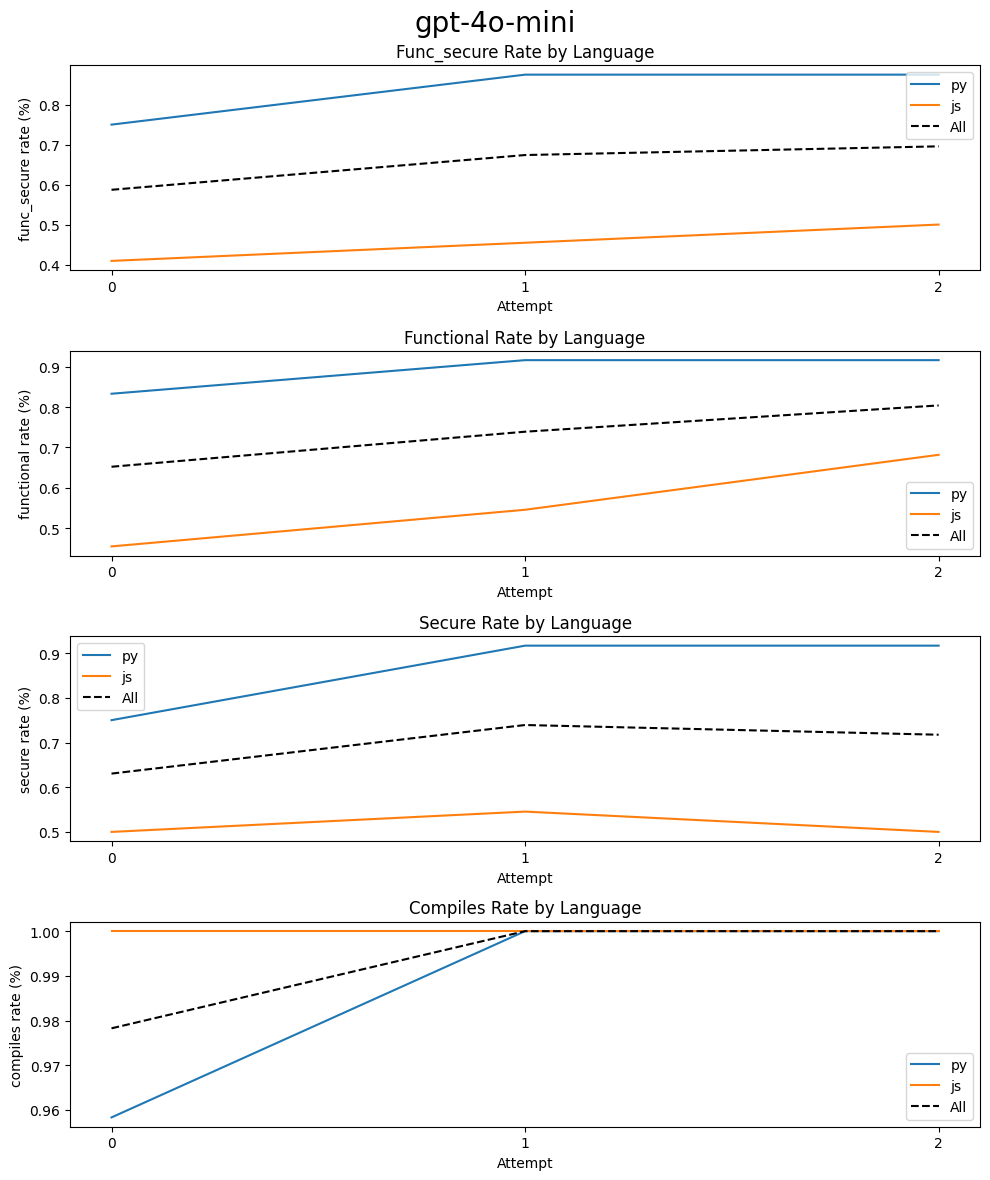

In [10]:
plot_stats_for_model(all_lang_stats_df, "gpt-4o-mini")